# S3 Project - 네이버 쇼핑 리뷰 자연어 처리 데이터 파이프라인 구축 
  
## 프로젝트 개요 
1. 주제 및 데이터 소개: 쇼핑 리뷰 자연어 처리 감성 분석  
    - 네이버 쇼핑 리뷰 데이터 활용 
2. 데이터 저장: 로컬 데이터베이스 MySQL 활용 
3. 데이터 분석: 네이버 쇼핑 리뷰 자연어 처리(NLP) 감성 분석 
    - 딥러닝(Deep Learning) GRU 알고리즘 적용, Tensorflow API 활용 
4. API 서비스 및 앱 애플리케이션 개발: Flask 활용 
5. 대시보드 작성: Metabase 활용 (MySQL DB 연동)  
6. 배포 및 향후 계획   

### 이 파일에서는 1. 주제 및 데이터 소개, 2. 데이터 저장 및 3. 데이버 분석 부분까지만 다룰 예정입니다.


In [1]:
# 분석에 필요한 기본 설정 
import re
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Okt
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import json 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.models import save_model

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_format='retina'

mpl.rc('font', family='AppleGothic')
mpl.rc('axes', unicode_minus=False)

2022-11-03 12:27:03.591362: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Part 1. 주제 및 데이터 소개 

## 1) 쇼핑 리뷰 분석의 필요성 
- 사람들의 구매 의사결정에 중요한 영향을 미치는 요인 
- 제품의 (불)만족 정도나 요소 파악 → 제품 성능 향상 데이터 및 고객 맞춤형 정보 제공 

## 2) 쇼핑 리뷰 분석의 어려움
- 하지만 다양한 매체, 많은 리뷰 축적 → 일일이 확인하고 분석하기 어려움
  - 홈페이지, 개인 블로그, 소셜 미디어(블로그, 인스타그램, 트위터 등)
- 대부분이 일상적인 용어로 작성되고 있음 → 컴퓨터가 바로 처리하기 어려움  
☞ 자연어 처리 기술을 통한 분석의 필요성 대두    
☞ 쇼핑 리뷰의 감성 분석(Sentiment Analysis): 리뷰 성격 분류 예측     

## 3) 데이터 소개: 네이버 쇼핑 리뷰   
- 데이터 특징  
  - 변수: 별점 (1~5점), 리뷰 (*3점 리뷰 제외)
  - 데이터 건수: 20만 건 → 분석 사용 199,391건 
  - 언어: 한국어
  - 출처: 네이버 쇼핑(https://shopping.naver.com/)
  - 수집 기간: 2020.06~2020.07      
  
- 데이터 출처: https://github.com/bab2min/corpus/tree/master/sentiment
 

## 4) 데이터 확인 및 전처리

In [2]:
# 데이터 불러오기 
DATA = './data/naver_shopping.txt' 

total_data = pd.read_table(DATA, names=['ratings', 'reviews'])
print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력

전체 리뷰 개수 : 200000


In [3]:
# 데이터 구조 확인 
total_data[:5]

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


In [4]:
# 별점 정보를 이용하여 라벨 변수 생성 (1~2: 부정(0), 4~5: 긍정(1))
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)
total_data[:5]

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


In [5]:
# 각 변수의 유일한 값 확인 
print(total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique())

4 199908 2


In [6]:
# reviews 중복 제거
total_data.drop_duplicates(subset=['reviews'], inplace=True) 
print('총 샘플의 수 :',len(total_data))

총 샘플의 수 : 199908


In [7]:
# 결측치 확인 
print(total_data.isnull().values.any())

False


### 자연어 처리를 위한 전처리

In [8]:
# 한글과 공백을 제외하고 모두 제거
total_data['reviews'] = total_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
total_data['reviews'].replace('', np.nan, inplace=True)

In [9]:
# 형태소 토큰화 및 불용어 제거
okt = Okt()
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

total_data['tokenized'] = total_data['reviews'].apply(okt.morphs)
total_data['tokenized'] = total_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

# 형태소 개수 변수 생성
total_data['text_len']= total_data['tokenized'].map(lambda x: len(x))

In [10]:
# 인덱스 재설정 
total_data.reset_index(inplace=True)


In [11]:
# 토큰화한 전체 데이터 csv로 저장 
total_data.to_csv('naver_total_data.csv')

In [12]:
# 데이터 Local DB 적재를 위한 데이터 최종 확정 
naver_shopping = total_data.drop(columns=['index', 'tokenized'])

## Part 2. 데이터 저장: 로컬 데이터베이스 MySQL 활용 

In [ ]:
import mysql.connector as mysql
from mysql.connector import Error
import os 
from dotenv import load_dotenv 
load_dotenv()

MYSQL_USER = os.getenv("mysql_user")
MYSQL_PASSWORD = os.getenv("mysql_password")

try:
    conn = mysql.connect(host = 'localhost', user = MYSQL_USER , password = MYSQL_PASSWORD,
                        db = 's3project')
    if conn.is_connected():
        cursor = conn.cursor()
        cursor.execute("select database();")
        record = cursor.fetchone()
        print("연결된 데이터 베이스: ", record)
        cursor.execute('DROP TABLE IF EXISTS naver_shopping;')
        print('테이블 생성 중...')
        # 테이블 생성 
        cursor.execute("""CREATE TABLE naver_shopping (id INT NOT NULL AUTO_INCREMENT PRIMARY KEY, 
                                                ratings INT, 
                                                reviews VARCHAR(1000), 
                                                label INT, 
                                                text_len INT
                                                ) DEFAULT CHARSET=utf8mb4;""")
 
        print("테이블 생성됨")
        # 데이터 프레임 입력을 위한 반복문
        for i,row in naver_shopping.iterrows():
            #here %S means string values 
            sql = "INSERT INTO s3project.naver_shopping (ratings, reviews, label, text_len) VALUES (%s, %s, %s, %s)"
            cursor.execute(sql, tuple(row))
            # 데이터 저장을 위한 커밋 
            conn.commit()
        print("레코드 입력 완료")
except Error as e:
            print("MySQL로 연결 중 에러 발생: ", e)

## Part 3. 데이터 분석: 감성 분석
- 딥러닝 GRU 모델 적용
- Tensorflow API 활용

## 1) 훈련용 데이터와 테스트용 데이터 구분

In [13]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 149931
테스트용 리뷰의 개수 : 49977


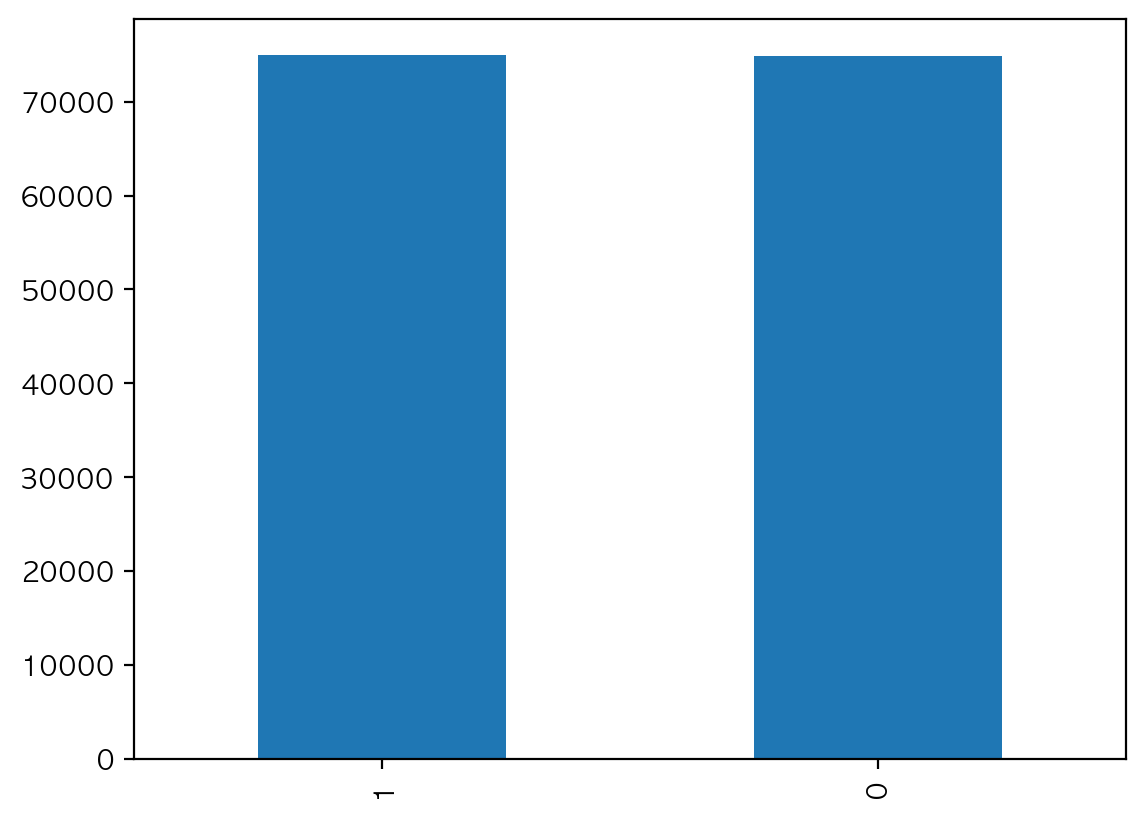

In [14]:
# 분포 확인 
train_data['label'].value_counts().plot(kind = 'bar');

In [15]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  74918
1      1  75013


## 2) 리뷰 성격별 자주 나오는 단어 및 길이 확인

In [16]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [17]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('너무', 13039), ('요', 11784), ('안', 11676), ('배송', 9171), ('그냥', 8518), ('잘', 7817), ('로', 5777), ('했는데', 5692), ('별로', 5549), ('못', 5174), ('제품', 5071), ('으로', 4999), ('생각', 4927), ('좀', 4878), ('사용', 4846), ('하고', 4769), ('ㅠㅠ', 4760), ('구매', 4634), ('보다', 4617), ('맛', 4017)]


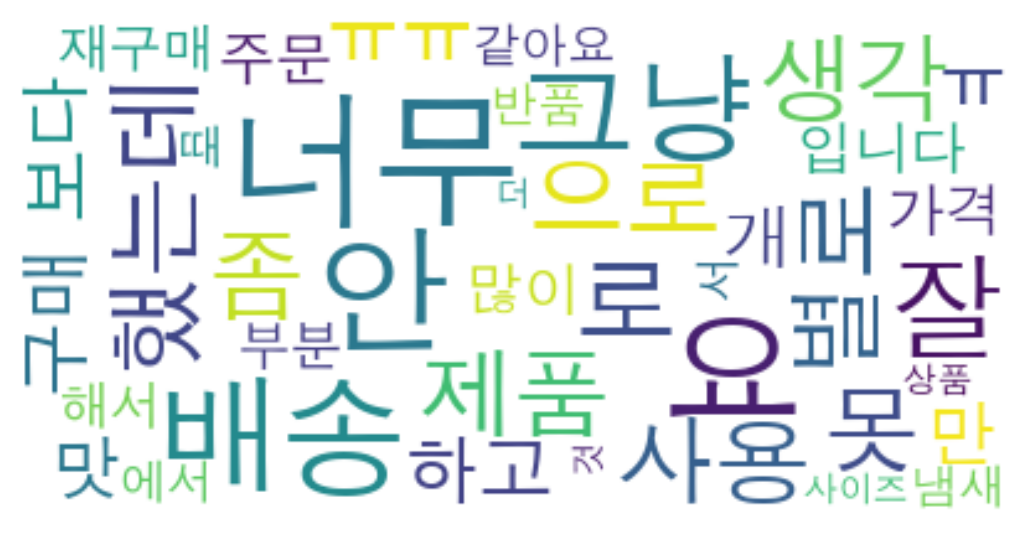

In [18]:
# (부정 리뷰) 워드 클라우드 작성 
from wordcloud import WordCloud

neg_wordcloud = WordCloud(font_path='AppleGothic.ttf', background_color='white', max_font_size=60).generate_from_frequencies(dict(negative_word_count.most_common(40)))
plt.imshow(neg_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

neg_wordcloud.to_file('neg_wordcloud.jpg')

In [19]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('잘', 15302), ('좋아요', 14527), ('배송', 12251), ('너무', 9100), ('재구매', 8573), ('구매', 7186), ('요', 6639), ('사용', 5415), ('가격', 5015), ('으로', 4477), ('같아요', 4434), ('로', 4318), ('좋네요', 4221), ('빠르고', 4025), ('보다', 3955), ('제품', 3950), ('주문', 3815), ('입니다', 3769), ('생각', 3491), ('했어요', 3367)]


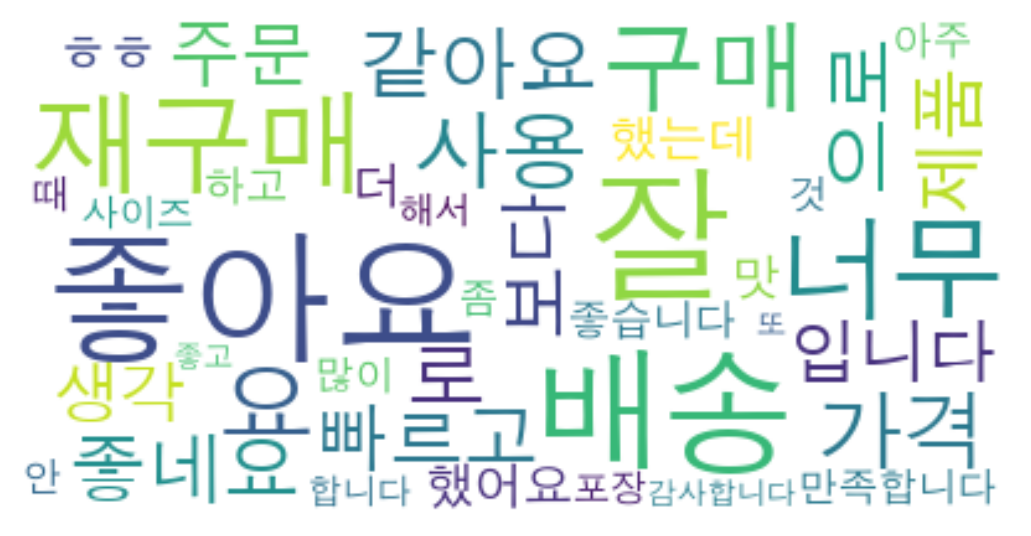

In [20]:
# (긍정 리뷰) 워드 클라우드 작성 
pos_wordcloud = WordCloud(font_path='AppleGothic.ttf', background_color='white', max_font_size=60).generate_from_frequencies(dict(positive_word_count.most_common(40)))
plt.imshow(pos_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

pos_wordcloud.to_file('pos_wordcloud.jpg')

긍정 리뷰의 평균 길이 : 10.768613440337008
부정 리뷰의 평균 길이 : 14.101804639739449


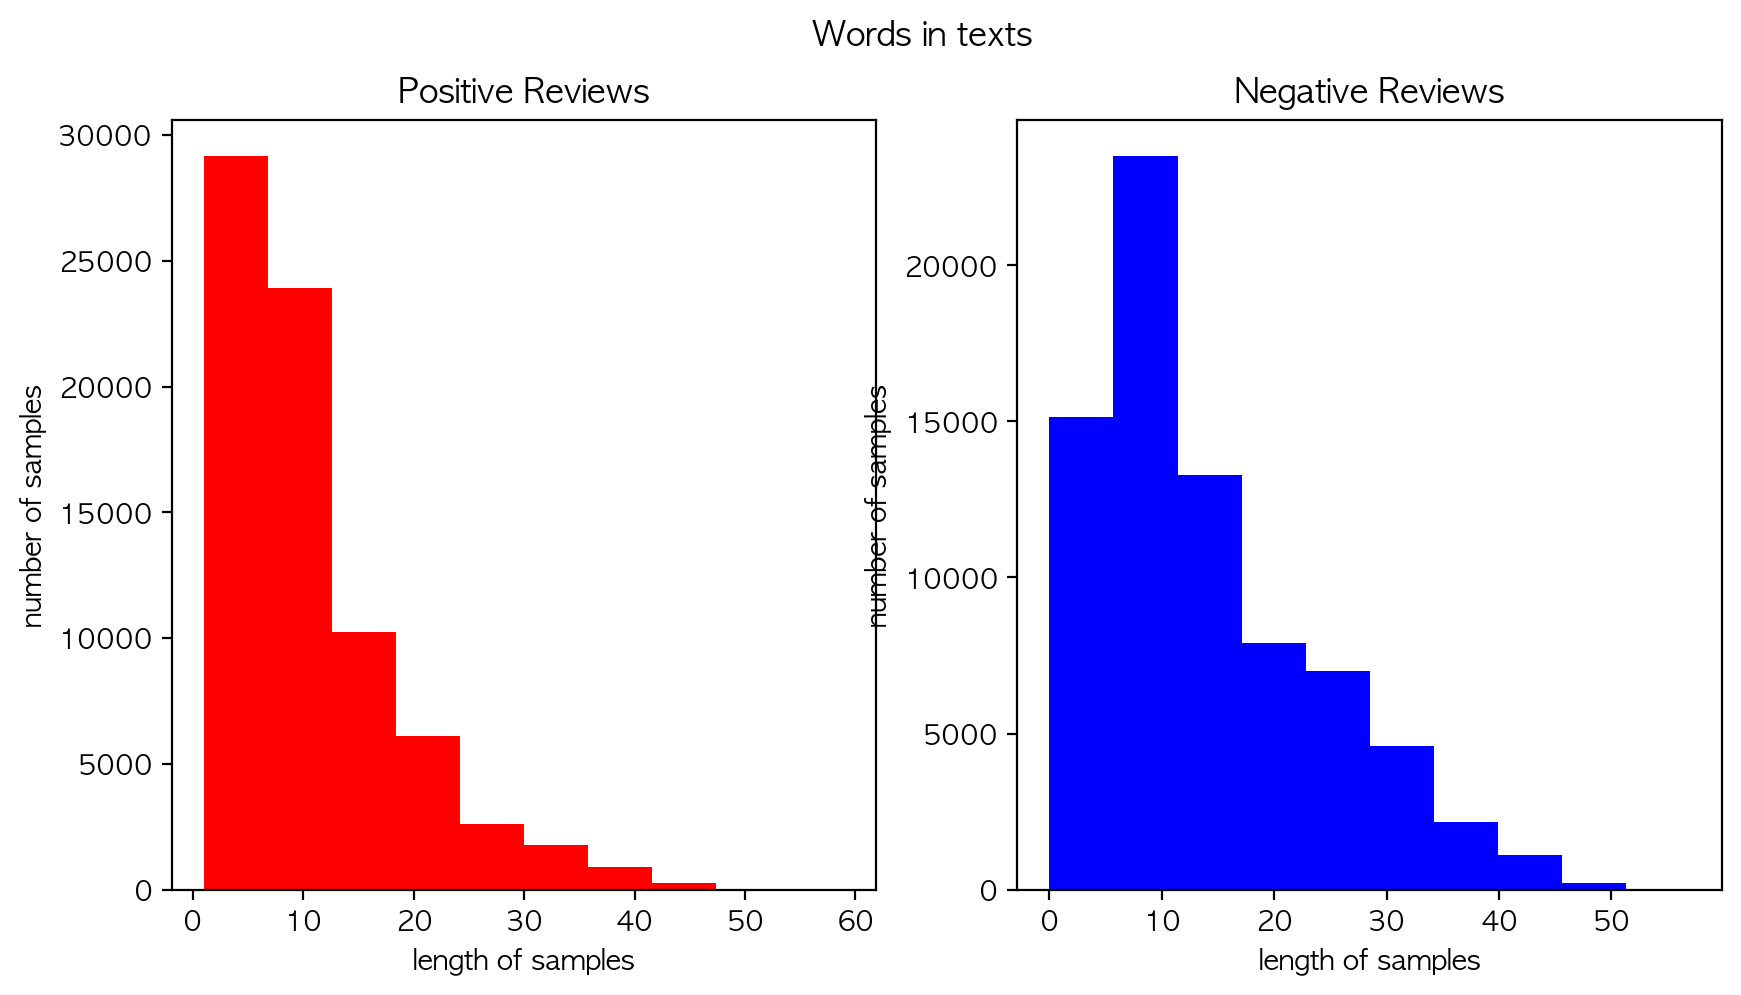

In [21]:
# 리뷰 성격별 단어 길이 확인 
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

## 3) 딥러닝 GRU 모델 학습

In [22]:
# 학습용 데이터 확정 
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [23]:
# 정수 인코딩 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [24]:
threshold = 2
total_cnt = len(tokenizer.word_index) 
rare_cnt = 0 
total_freq = 0 
rare_freq = 0 

# 단어와 빈도수의 쌍(pair) 확인 
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if (value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 94361
등장 빈도가 1번 이하인 희귀 단어의 수: 52344
단어 집합에서 희귀 단어의 비율: 55.47207002893144
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.807755335212537


In [25]:
# 빈도수 2이하인 단어 개수는 제거
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 42019


In [26]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# 단어 사전 저장
word_vocab = tokenizer.word_index 

In [27]:
print(X_train[:3])

[[33, 2263, 274, 1, 294, 174, 105, 78, 328, 5, 9212, 790, 5, 34, 25, 1637, 1036, 391, 92, 6], [2867, 1494, 4132, 3159, 3194, 260, 1, 1], [14, 139, 6114, 318, 2720, 504, 2, 7, 30070, 946, 52, 29, 100, 2995, 170, 504, 100, 2, 13635, 7396, 4010, 5, 69, 18012]]


In [28]:
print(X_test[:3])

[[3, 6886, 778, 2095, 151, 2214], [260, 7279, 25, 5281], [4, 714, 16, 96, 64, 32, 20, 496, 131, 1, 67, 2837, 2, 117]]


리뷰의 최대 길이 : 59
리뷰의 평균 길이 : 12.43415304373345


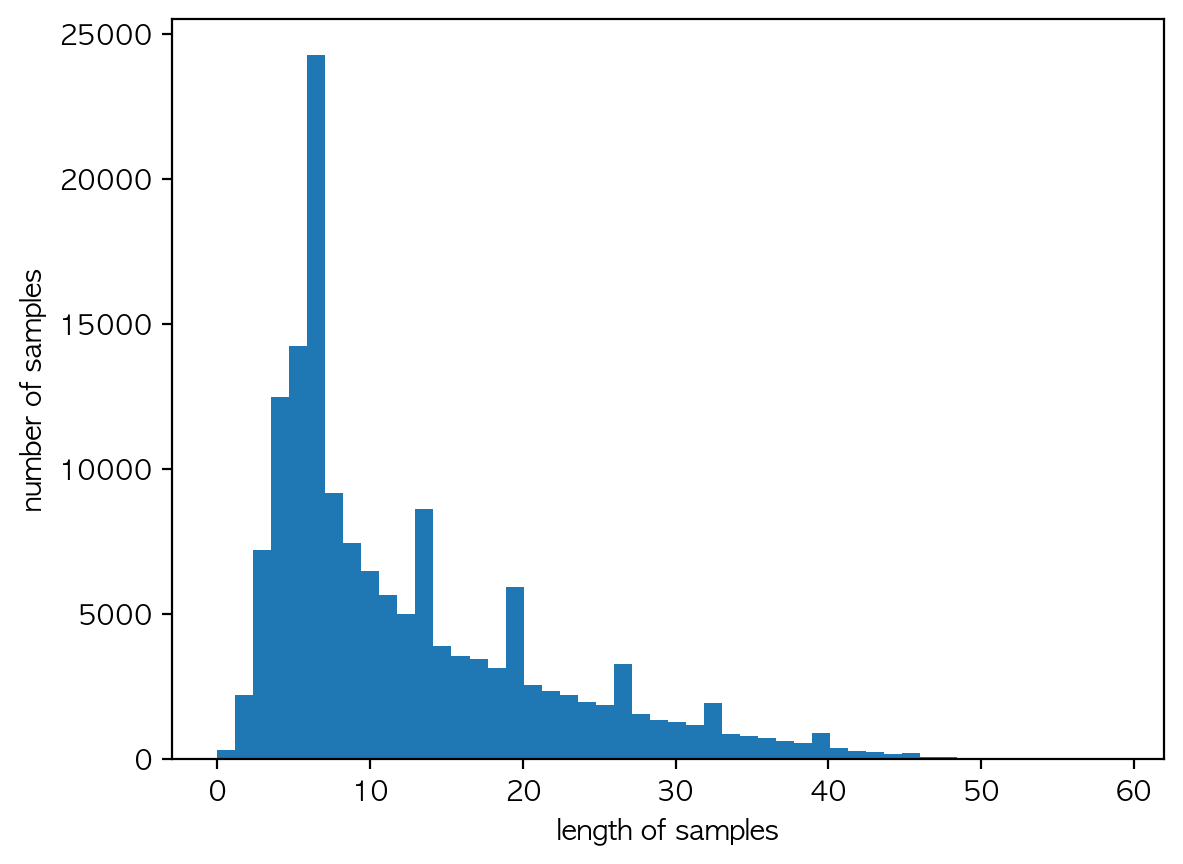

In [30]:
# 패딩: 리뷰 길이 맞추주기 
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [31]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [32]:
max_len = 80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 100.0


In [33]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [34]:
# 향후 재사용 가능하도록 데이터 저장 
DATA_PATH = './data/'
TRAIN_INPUT_DATA = 'naver_train_input.npy'
TRAIN_LABEL_DATA = 'naver_train_label.npy'
TEST_INPUT_DATA = 'naver_test_input.npy'
TEST_LABEL_DATA = 'naver_test_label.npy'
DATA_CONFIGS = 'data_configs.json'

data_configs={}
data_configs['vocab'] = word_vocab
data_configs['vocab_size'] = len(word_vocab) + 1

# 전처리한 데이터들 파일로저장
import os

if not os.path.exists(DATA_PATH):
  os.makedirs(DATA_PATH)

# 전처리 학습데이터 넘파이로 저장
np.save(open(DATA_PATH + TRAIN_INPUT_DATA,'wb'), X_train)
np.save(open(DATA_PATH + TRAIN_LABEL_DATA,'wb'), y_train)
# 전처리 테스트데이터 넘파이로 저장
np.save(open(DATA_PATH + TEST_INPUT_DATA,'wb'), X_test)
np.save(open(DATA_PATH + TEST_LABEL_DATA,'wb'), y_test)

# 데이터 사전 json으로 저장
json.dump(data_configs, open(DATA_PATH + DATA_CONFIGS,'w'), ensure_ascii=False)

### 딥러닝 GRU 모델 적용

In [35]:
# 딥러닝 GRU 모델 적용: 네이버 쇼핑 리뷰 감성 분석

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

2022-11-03 12:55:10.117162: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/15
1875/1875 [==============================] - ETA: 0s - loss: 0.2768 - acc: 0.8939
Epoch 1: val_acc improved from -inf to 0.90823, saving model to best_model.h5
1875/1875 [==============================] - 203s 107ms/step - loss: 0.2768 - acc: 0.8939 - val_loss: 0.2528 - val_acc: 0.9082
Epoch 2/15
1875/1875 [==============================] - ETA: 0s - loss: 0.2188 - acc: 0.9213
Epoch 2: val_acc improved from 0.90823 to 0.91480, saving model to best_model.h5
1875/1875 [==============================] - 201s 107ms/step - loss: 0.2188 - acc: 0.9213 - val_loss: 0.2284 - val_acc: 0.9148
Epoch 3/15
1875/1875 [==============================] - ETA: 0s - loss: 0.1978 - acc: 0.9302
Epoch 3: val_acc improved from 0.91480 to 0.92003, saving model to best_model.h5
1875/1875 [==============================] - 202s 108ms/step - loss: 0.1978 - acc: 0.9302 - val_loss: 0.2201 - val_acc: 0.9200
Epoch 4/15
1875/1875 [==============================] - ETA: 0s - loss: 0.1834 - acc: 0.9367
Epoch 4

In [36]:
# 모델 아키텍처 보기 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         4201900   
                                                                 
 gru (GRU)                   (None, 128)               88320     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 4,290,349
Trainable params: 4,290,349
Non-trainable params: 0
_________________________________________________________________


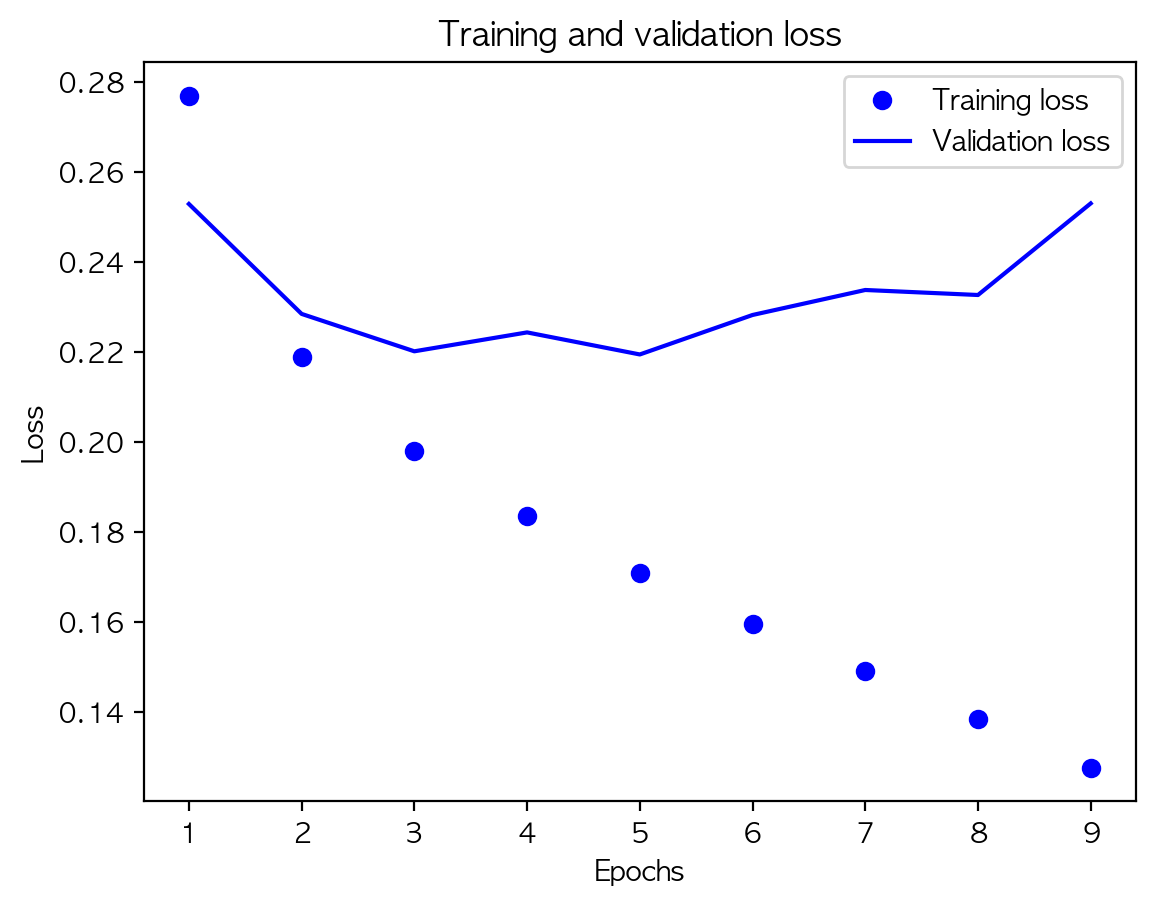

In [37]:
# 손실 그래프 그리기 
history_dict = history.history
history_dict.keys()

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss') # "bo"는 "파란색 점"
plt.plot(epochs, val_loss, 'b', label='Validation loss') # b는 "파란 실선"
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

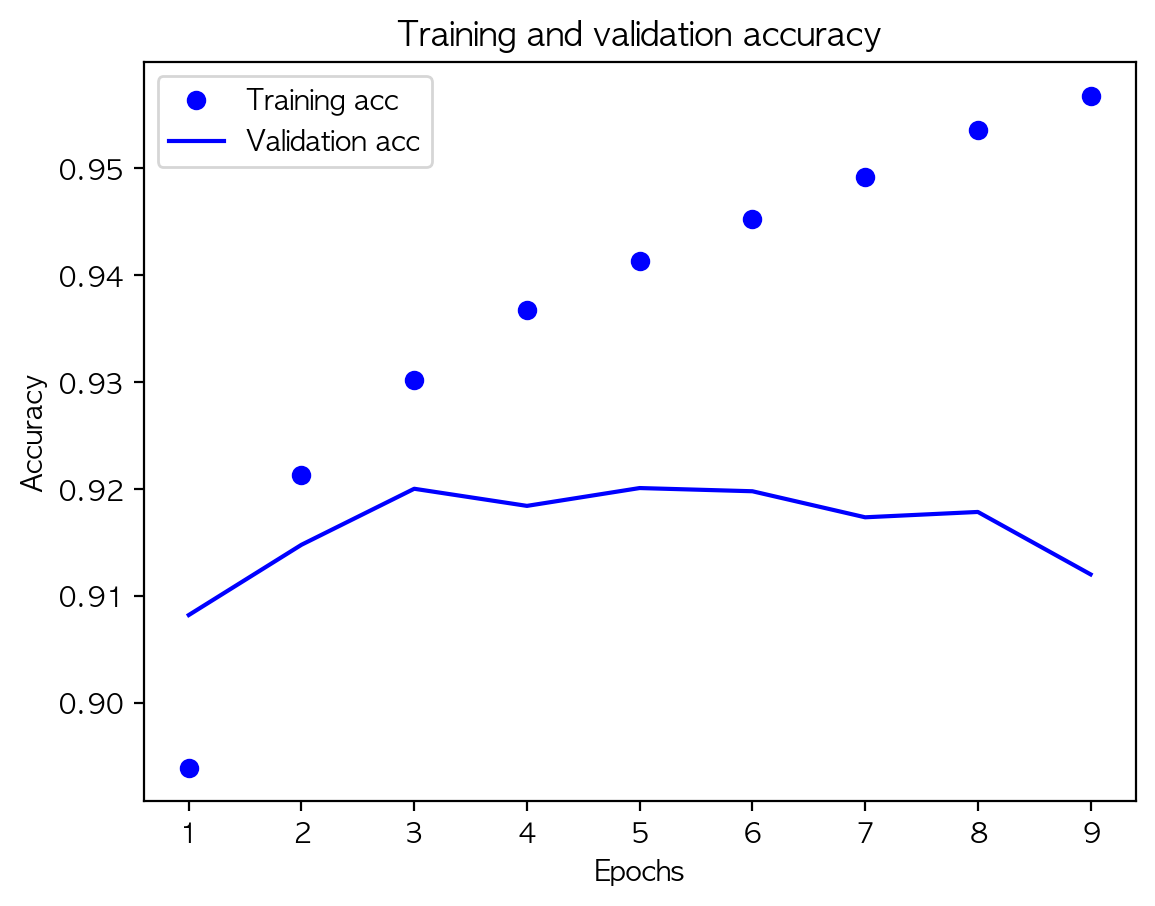

In [38]:
# 정확도 그래프 그리기 
plt.clf()   # 그림 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 4) 쇼핑 리뷰 예측

In [39]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1562/1562 [==============================] - 31s 20ms/step - loss: 0.2232 - acc: 0.9183

 테스트 정확도: 0.9183


In [40]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)

  score = float(loaded_model.predict(pad_new))
  if (score > 0.5):
      result = "고객님의 리뷰를 긍정 리뷰로 분류할 수 있는 확률은 {:.2f}%입니다.".format(score * 100)
  else:
      result = "고객님의 리뷰를 부정 리뷰로 분류할 수 있는 확률은 {:.2f}%입니다.".format((1 - score) * 100)
  return result

In [41]:
sentiment_predict('이 상품 정말 마음에 듭니다. 강추합니다.')

1/1 [==============================] - 1s 583ms/step


'고객님의 리뷰를 긍정 리뷰로 분류할 수 있는 확률은 99.12%입니다.'

In [42]:
sentiment_predict('배송도 느리고 물건도 별로예요. 다시 구매는 안할 것 같습니다.')

1/1 [==============================] - 0s 40ms/step


'고객님의 리뷰를 부정 리뷰로 분류할 수 있는 확률은 99.85%입니다.'

In [43]:
sentiment_predict('이 상품은 제가 원하던 것과 달라요.')

1/1 [==============================] - 0s 34ms/step


'고객님의 리뷰를 부정 리뷰로 분류할 수 있는 확률은 78.43%입니다.'

### 4. API 서비스 및 앱 애플리케이션 개발(Flask 활용), 5. 대시보드 작성(Metabase 활용 - Local DB 연동) 등의 내용은 별도로 작성되었습니다. 
### 참고해 주세요. 감사합니다. 